You can find a detailed explanation for this dataset in [this](https://www.kaggle.com/code/iamsouravbanerjee/the-best-journeys-takes-you-home) notebook by Sourav Banerjee.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.rcParams["figure.figsize"] = (10,5)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#read csv file
rent_data = pd.read_csv('/kaggle/input/house-rent-prediction-dataset/House_Rent_Dataset.csv')
print(f"Number of rows and features in the df: {rent_data.shape}")

Number of rows and features in the df: (4746, 12)


In [3]:
rent_data.sample(3)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
68,2022-05-18,2,6500,800,Ground out of 2,Carpet Area,"Chak Thakurani, Thakurpukur",Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
2401,2022-05-04,2,10000,450,3 out of 4,Carpet Area,Pandav Nagar,Delhi,Unfurnished,Bachelors/Family,1,Contact Owner
3978,2022-05-06,3,24000,1200,1 out of 3,Super Area,"Kachiguda, NH 2 2",Hyderabad,Semi-Furnished,Bachelors/Family,4,Contact Owner


In [4]:
rent_data.describe().T

,count,mean,std,min,25%,50%,75%,max
BHK,4746.0,2.083860,0.832256,1.0,2.0,2.0,3.0,6.0
Rent,4746.0,34993.451327,78106.412937,1200.0,10000.0,16000.0,33000.0,3500000.0
Size,4746.0,967.490729,634.202328,10.0,550.0,850.0,1200.0,8000.0
Bathroom,4746.0,1.965866,0.884532,1.0,1.0,2.0,2.0,10.0


- Number of bedrooms range from 1 to 6 with 75% of houses offering below 3 bedrooms.  
- 75% of houses offer 2 or less bathrooms with 1 house with 10 bathrooms. This seems like an outlier. We will check the distribution of these quantities in upcoming plots.

In [5]:
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [6]:
#checking for NULL values
rent_data.isnull().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

None of the column contains missing values.

In [7]:
#checking for duplicates
rent_data.duplicated().sum()

0

#### Check the range of dates in 'Posted On' column.
The house listings are of months- April, May, June and July of 2022.

In [5]:
#convert date column from object to actual datetime
rent_data['Posted On'] = pd.to_datetime(rent_data['Posted On'])
#check unique months and year in the dates
rent_data['Posted On'].dt.strftime('%b-%Y').unique()

array(['May-2022', 'Jul-2022', 'Apr-2022', 'Jun-2022'], dtype=object)

In [9]:
#list of all column names
rent_data.columns.values.tolist()

['Posted On',
 'BHK',
 'Rent',
 'Size',
 'Floor',
 'Area Type',
 'Area Locality',
 'City',
 'Furnishing Status',
 'Tenant Preferred',
 'Bathroom',
 'Point of Contact']

#### Check all unique values in 'Area type', 'Furnishing Status', 'Number of Floors' & 'City'

In [6]:
#Area Type
print(rent_data['Area Type'].unique())

['Super Area' 'Carpet Area' 'Built Area']


In [11]:
#total number of data points with each area type
rent_data.groupby('Area Type')['Area Type'].agg('count')

Area Type
Built Area        2
Carpet Area    2298
Super Area     2446
Name: Area Type, dtype: int64

In [12]:
#Furnishing Status
print(rent_data['Furnishing Status'].unique())

['Unfurnished' 'Semi-Furnished' 'Furnished']


In [13]:
#total number of observations with each furnishing type
rent_data.groupby('Furnishing Status')['Furnishing Status'].agg('count')

Furnishing Status
Furnished          680
Semi-Furnished    2251
Unfurnished       1815
Name: Furnishing Status, dtype: int64

#### Furnishing status per room

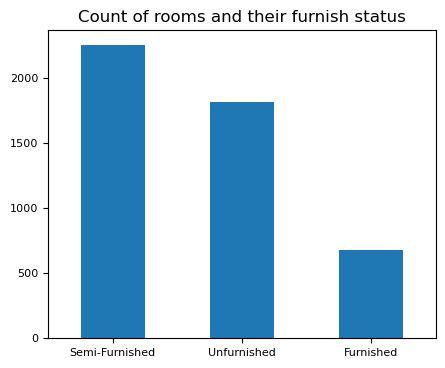

In [7]:
plt.figure(figsize = (5,4))
rent_data['Furnishing Status'].value_counts().plot(kind = 'bar', rot = 0)
plt.title("Count of rooms and their furnish status")
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

In [14]:
#Number of Floors
rent_data['Floor'].unique().tolist()

['Ground out of 2',
 '1 out of 3',
 '1 out of 2',
 'Ground out of 1',
 'Ground out of 4',
 '1 out of 4',
 '1 out of 1',
 'Ground out of 3',
 '2 out of 3',
 '4 out of 5',
 '2 out of 2',
 '2 out of 5',
 '4 out of 14',
 '3 out of 3',
 '5 out of 5',
 '4 out of 4',
 '7 out of 8',
 '2 out of 4',
 '3 out of 4',
 '1 out of 5',
 '8 out of 5',
 'Ground out of 6',
 '2 out of 1',
 'Upper Basement out of 4',
 'Ground out of 5',
 '3 out of 5',
 '11 out of 19',
 '5 out of 10',
 '11 out of 14',
 'Lower Basement out of 2',
 '2 out of 7',
 '4 out of 10',
 '7 out of 10',
 '2 out of 13',
 '6 out of 7',
 '4 out of 7',
 '14 out of 14',
 '43 out of 78',
 '2 out of 8',
 '13 out of 18',
 '5 out of 12',
 '18 out of 24',
 '3 out of 7',
 '17 out of 31',
 '11 out of 21',
 '7 out of 19',
 '14 out of 23',
 '9 out of 20',
 'Upper Basement out of 9',
 '19 out of 24',
 '3 out of 21',
 '1 out of 22',
 '8 out of 8',
 '6 out of 12',
 '4 out of 58',
 'Upper Basement out of 16',
 '60 out of 66',
 '34 out of 48',
 '5 out of 

In [ ]:
#ground_floor = rent_data[rent_data['Floor'].str.contains('ground', case = False)]

In [9]:
#make a copy of floor column; all modification will be done in new column
rent_data['floor_number'] = rent_data['Floor']

### Get the row numbers for all patterns in which floors are written

In [10]:
#rows with ground floor
ground_floor_i = rent_data[rent_data['floor_number'].str.contains('ground', case = False)].index
#rows that contain "upper basement"
upper_basement_i = rent_data[rent_data['floor_number'].str.contains('upper basement', case = False)].index
#rows that contain "lower basement"
lower_basement_i = rent_data[rent_data['floor_number'].str.contains('lower basement', case = False)].index
#rows that contain "out of"
out_of_i = rent_data[rent_data['floor_number'].str.contains('out of', case = False)].index

In [11]:
#change 'ground' floor to 0
rent_data.loc[ground_floor_i,'floor_number'] = '0'
#change 'upper basement' to 1
rent_data.loc[upper_basement_i, 'floor_number'] = '1'
#change lower basement to 0
rent_data.loc[lower_basement_i, 'floor_number'] = '0'
#in rows containing 'out of', keep the first argument
#e.g. in '1 out of 5', keep '1' as the floor count
rent_data.loc[out_of_i, 'floor_number'] = rent_data.loc[out_of_i, 'floor_number'].str.split(" out of ", expand = True)[0]

In [12]:
rent_data.loc[:, ['Floor', 'floor_number']].sample(5)

,Floor,floor_number
3981,1 out of 3,1
3546,2 out of 2,2
2620,2 out of 3,2
398,1 out of 2,1
628,2 out of 6,2


In [13]:
#convert floor_number column to numeric
rent_data['floor_number'] = pd.to_numeric(rent_data['floor_number'])

In [20]:
rent_data.columns

Index(['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type',
       'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred',
       'Bathroom', 'Point of Contact', 'floor_number'],
      dtype='object')

In [14]:
#checking all unique values in BHK column
rent_data['BHK'].unique()

array([2, 1, 3, 6, 4, 5])

In [57]:
#all unique values in City
rent_data['City'].unique()

array(['Kolkata', 'Mumbai', 'Bangalore', 'Delhi', 'Chennai', 'Hyderabad'],
      dtype=object)

The above Indian cities ranking from lower to higher cost of living are as follows:  
Check the full list [here](https://www.statista.com/statistics/1399330/india-cost-of-living-index-by-city/#:~:text=As%20of%20July%202023%2C%20Noida,Mumbai%2C%20Bengaluru%2C%20and%20Hyderabad.).
- Kolkata- 1
- Chennai- 2
- Delhi- 3
- Hyderabad- 4
- Bangalore- 5
- Mumbai- 6

In [15]:
#add city column with rank progressing from lower cost of living to higher
rent_data['city'] = np.where(rent_data['City'] == 'Kolkata', 1,
                    np.where(rent_data['City'] == 'Chennai', 2,
                    np.where(rent_data['City'] == 'Delhi', 3,
                    np.where(rent_data['City'] == 'Hyderabad', 4,
                    np.where(rent_data['City'] == 'Bangalore', 5, 6)
                    ))))

In [59]:
rent_data['Furnishing Status'].unique()

array(['Unfurnished', 'Semi-Furnished', 'Furnished'], dtype=object)

- Unfurnished- 1
- Semi-Furnished- 2  
- Furnished- 3

In [16]:
#quantify furnish status
rent_data['furnish'] = np.where(rent_data['Furnishing Status'] == 'Unfurnished', 1,
                               np.where(rent_data['Furnishing Status'] == 'Semi-Furnished', 2, 3))

In [17]:
#number of houses with each tenant-type preferred
rent_data.groupby('Tenant Preferred')['Tenant Preferred'].agg('count')

Tenant Preferred
Bachelors            830
Bachelors/Family    3444
Family               472
Name: Tenant Preferred, dtype: int64

In [ ]:
rent_data.columns

In [19]:
#keeping only relevant columns
final_data = rent_data.loc[:,['BHK', 'Size', 'floor_number', 'furnish', 'Bathroom', 'city', 'Rent']]

In [20]:
#change column names to lowercase
final_data = final_data.rename(columns = str.lower)

In [32]:
#Normalize the dataset
from sklearn.preprocessing import StandardScaler
#create an instance
zscore_scaler = StandardScaler().set_output(transform = "pandas")

In [33]:
data_norm = zscore_scaler.fit_transform(final_data)

In [23]:
#compute mean and standard deviation of the features
#zscore_scaler.fit(final_data)
#scale the features using the mean and standard dev
#zscore_scaler.transform(final_data)

array([[-1.00773006e-01,  2.08960497e-01, -5.98628269e-01, ...,
         3.85939877e-02, -1.64440376e+00, -3.20026025e-01],
       [-1.00773006e-01, -2.64124507e-01, -4.25137199e-01, ...,
        -1.09206691e+00, -1.64440376e+00, -1.91982074e-01],
       [-1.00773006e-01,  5.12654953e-02, -4.25137199e-01, ...,
        -1.09206691e+00, -1.64440376e+00, -2.30395259e-01],
       ...,
       [ 1.10090711e+00,  1.23397800e+00, -7.81550586e-02, ...,
         1.16925489e+00,  1.41622690e-01,  8.38517907e-05],
       [ 1.10090711e+00,  8.39740502e-01,  3.39166634e+00, ...,
         3.85939877e-02,  1.41622690e-01,  1.28127802e-01],
       [-1.00773006e-01,  5.12654953e-02,  9.53360116e-02, ...,
         3.85939877e-02,  1.41622690e-01, -2.56004050e-01]])

In [35]:
data_norm.describe()

,bhk,size,floor_number,furnish,bathroom,city,rent
count,4.746000e+03,4.746000e+03,4746.000000,4.746000e+03,4.746000e+03,4.746000e+03,4746.000000
mean,2.994280e-17,8.982841e-17,0.000000,-5.988561e-17,-1.197712e-16,-4.790849e-17,0.000000
std,1.000105e+00,1.000105e+00,1.000105,1.000105e+00,1.000105e+00,1.000105e+00,1.000105
min,-1.302453e+00,-1.509915e+00,-0.598628,-1.111575e+00,-1.092067e+00,-1.644404e+00,-0.432705
25%,-1.007730e-01,-6.583620e-01,-0.425137,-1.111575e+00,-1.092067e+00,-1.049062e+00,-0.320026
50%,-1.007730e-01,-1.852770e-01,-0.251646,3.493872e-01,3.859399e-02,1.416227e-01,-0.243200
75%,1.100907e+00,3.666555e-01,-0.078155,3.493872e-01,3.859399e-02,7.369648e-01,-0.025525
max,4.705947e+00,1.108992e+01,12.586693,1.810349e+00,9.083881e+00,1.332307e+00,44.367313


#### 1. Is there any relationship between Size of house and Rent?

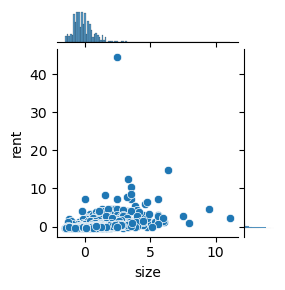

In [37]:
sns.jointplot(x = data_norm['size'], y = data_norm['rent'], height = 3)
plt.show()

In [ ]:
#x = data_norm.drop()

In [ ]:
# fig, axes = plt.subplots(1,6, constrained_layout = True, sharey = True)
# for i in range(len(axes)):
#     axes[i].scatter(data_norm.loc[:,''])


In [64]:
feature_name = final_data.columns

Index(['bhk', 'size', 'floor_number', 'furnish', 'bathroom', 'city', 'rent'], dtype='object')